[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/intel-analytics/BigDL/blob/main/python/chronos/colab-notebook/howto/how_to_preprocess_my_data.ipynb)

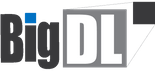

# Preprocess my own data

## Introduction

As we all know, data is the core part of machine learning and deep learning, and how we preprocess our own data greatly influence the results of training.

Usually, there maybe some low quality data like wrong datetime type, missing value, inconsitent time interval in our own data. We need to fix these problems for better training. Also we may need to do some feature engineering work for better accuracy.

`TSDataset` provides a bunch of functions to help you deal with above cases. In this guidance, **we demonstrate how to preprocess my own data** in detail.

We will take random dataframe as an example in this guide.

## Setup
Before we begin, we need to install chronos if it isn’t already available, we choose to use pytorch as deep learning backend.

In [ ]:
!pip install --pre --upgrade bigdl-chronos[pytorch]
!pip uninstall -y torchtext

## Initialize TSDataset

Here we take a random pandas dataframe `df` as an example, you can see the first five samples of this dateframe:

In [8]:
import pandas as pd
import numpy as np

data = np.random.random_sample((100, 5))
mask = np.random.random_sample((100, 5))
newmask = mask.copy()
mask[newmask >= 0.4] = 2
mask[newmask < 0.4] = 1
mask[newmask < 0.2] = 0
data[mask == 0] = None
data[mask == 1] = np.nan
df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd', 'e'])
df['a'][0] = np.nan  # make sure column 'a' has a N/A
df["datetime"] = pd.date_range('1/1/2019', periods=100)
df.loc[50:100, "datetime"] = pd.date_range('1/1/2019', periods=50)
df["id"] = np.array(['00']*50 + ['01']*50)
df.loc[3, "datetime"] = "1/2/2019"

In [9]:
df.head()

,a,b,c,d,e,datetime,id
0,NaN,NaN,NaN,0.439440,0.741009,2019-01-01 00:00:00,00
1,0.595070,0.030522,0.739803,0.452446,0.593899,2019-01-02 00:00:00,00
2,0.032905,NaN,NaN,NaN,0.685142,2019-01-03 00:00:00,00
3,0.517125,0.131058,0.491102,NaN,NaN,1/2/2019,00
4,0.116797,0.270899,NaN,0.876024,0.980061,2019-01-05 00:00:00,00


First you should initialize a TSDataset by `TSDataset.from_pandas` and now we provide automatic quality check during the initialization process. Therefore, if :

* your datetime column has a wrong type
  
* there exsits missing value in your data
  
* there are inconsitent time interval in your data
  
You will see warnings after initialization.

In [ ]:
from bigdl.chronos.data import TSDataset

tsdata_train, _, tsdata_test = TSDataset.from_pandas(df,
                                                     id_col="id",
                                                     dt_col="datetime",
                                                     target_col=['a', 'b', 'c', 'd', 'e'],
                                                     extra_feature_col=None,
                                                     with_split=True)

> 📝**Note**
> 
> - If your data is a parquet file, you should call `TSDataset.from_parquet`.
> - If your data is stored in Prometheus, you should call  `TSDataset.from_prometheus`.

## Preprocess data

There are two ways for you to preprocess your data: automatic repair or preprocess manually. You can combine the two ways together or just choose the second way to preprocess your data.

### Automatic repair

During your initialzation, if you see warnings, you can choose automatic data repair by setting `repair=True` in initialzation, which will:

* change your datetime column to datetime64 type
  
* resample your data based on mode of time interval
  
* fill your missing data


In [ ]:
from bigdl.chronos.data import TSDataset

tsdata_train, _, tsdata_test = TSDataset.from_pandas(df,
                                                     id_col="id",
                                                     dt_col="datetime",
                                                     target_col=['a', 'b', 'c', 'd', 'e'],
                                                     extra_feature_col=None,
                                                     with_split=True,
                                                     repair=True)

Below is the repaired dataframe, as you can see, time interval is consitent now and missing values have been filled.

In [12]:
tsdata_train.df.head()

,datetime,a,b,c,d,e,id
0,2019-01-01,0.556098,0.080790,0.615452,0.439440,0.741009,00
1,2019-01-02,0.556098,0.080790,0.615452,0.452446,0.593899,00
2,2019-01-03,0.032905,0.144160,0.674160,0.593639,0.685142,00
3,2019-01-04,0.074851,0.207529,0.732868,0.734831,0.832602,00
4,2019-01-05,0.116797,0.270899,0.791577,0.876024,0.980061,00


### Preprocess data manually

`TSDataset` provides a bunch of functions to help you process your data:

* impute : fill in missing value

* resample :  resample on a new interval for each univariate time series distinguished by id_col and feature_col

* deduplicate: remove those duplicated records

* scale: scale the time series dataset's feature column and target column according to a sklearn scaler instance

And theses method can be cascaded. A common processing method is as follows:

In [13]:
from sklearn.preprocessing import StandardScaler
stand = StandardScaler()

for tsdata in [tsdata_train, tsdata_test]:
    tsdata.deduplicate().impute()\
            .scale(stand, fit=tsdata is tsdata_train)

You can also do some feature engineering work. For example, `TSDataset` provides `gen_gt_feature` to generate datetime feature(s) for each record.

In [ ]:
tsdata_train.gen_dt_feature()
tsdata_test.gen_dt_feature()

Now take a look at the new dataframe again. Obviously value range has changed by `scale` and new datetime features (DAY, DAYODYEAR, WEEKOFYEAR, MONTH, YEAR, IS_WEEKEND) have been added by `gen_dt_feature`.

In [15]:
tsdata_train.df.head()

,datetime,a,b,c,d,e,id,DAY,DAYOFYEAR,WEEKDAY,WEEKOFYEAR,MONTH,YEAR,IS_WEEKEND
0,2019-01-01,0.280584,-1.448139,0.272633,-0.284876,0.829947,00,1,1,1,1,1,2019,0
1,2019-01-02,0.280584,-1.448139,0.272633,-0.235544,0.282492,00,2,2,2,1,1,2019,0
2,2019-01-03,-2.089437,-1.201914,0.501847,0.300001,0.622045,00,3,3,3,1,1,2019,0
3,2019-01-04,-1.899425,-0.955689,0.731060,0.835545,1.170800,00,4,4,4,1,1,2019,0
4,2019-01-05,-1.709413,-0.709464,0.960274,1.371090,1.719554,00,5,5,5,1,1,2019,1


Then you have finished basic data preprocessing. The next step, for deep learning, you should roll your data according to lookback and horizon, which will be introduced in another guidance []() in detail.